In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 전역 폰트 크기 설정
FONT_SIZE = 50  # 텍스트 크기
LABEL_FONT_SIZE = 30  # 예측 값 폰트 크기
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # 폰트 경로
THRESHOLD = 0.8  # 신뢰도 임계값

# YOLO 모델 로드
yolo_model_path = "yolov8n.pt"  # YOLO 모델 경로
yolo_model = YOLO(yolo_model_path)

# 클래스 매핑 및 색상
class_indices = {'BUS': 0, 'Bike': 1, 'Common': 2, 'Truck': 3}
index_to_class = {v: k for k, v in class_indices.items()}
class_colors = {
    'BUS': "blue",
    'Bike': "green",
    'HatchBack': "yellow",
    'SUV': "red",
    'Sedan': "cyan",
    'Truck': "purple",
    'Truck2': "magenta",
    'Van': "brown",
    'Common': "orange"
}

img_size = (128, 128)

def add_centered_text(draw, image, text, font_path=FONT_PATH, font_size=FONT_SIZE, color="black", bg_color="white", padding=10):

    """
    이미지 상단 중앙에 텍스트 추가 함수
    """
    if font_path:
        font = ImageFont.truetype(font_path, font_size)  # TrueType 폰트 사용
    else:
        font = ImageFont.load_default()  # 기본 폰트 사용

    image_width, image_height = image.size

    # 텍스트 크기 계산
    text_bbox = font.getbbox(text)  # 텍스트 경계 계산
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # 중앙 위치 계산
    x = (image_width - text_width) // 2
    y = 10  # 위쪽 여백

    # 배경 사각형 좌표 계산 (패딩 포함)
    bg_x1 = x - padding
    bg_y1 = y - padding
    bg_x2 = x + text_width + padding
    bg_y2 = y + text_height + padding

    # 배경 사각형 그리기
    draw.rectangle([bg_x1, bg_y1, bg_x2, bg_y2], fill=bg_color)

    # 텍스트 추가
    draw.text((x, y), text, font=font, fill=color)

def add_text(draw, x, y, text, font_path=FONT_PATH, font_size=LABEL_FONT_SIZE, color="black"):
    """
    지정된 위치에 텍스트 추가 함수
    """
    if font_path:
        font = ImageFont.truetype(font_path, font_size)  # TrueType 폰트 사용
    else:
        font = ImageFont.load_default()  # 기본 폰트 사용

    # 텍스트 추가
    draw.text((x, y), text, font=font, fill=color)

def plot_image_with_matplotlib(image, title="Image"):
    """
    이미지를 Matplotlib로 출력
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

def crop_to_square(image, box):
    """
    긴 쪽을 기준으로 정사각형으로 크롭
    """
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    size = max(width, height)

    # 중심 계산
    center_x = x1 + width // 2
    center_y = y1 + height // 2

    # 정사각형 좌표 계산
    new_x1 = max(center_x - size // 2, 0)
    new_y1 = max(center_y - size // 2, 0)
    new_x2 = new_x1 + size
    new_y2 = new_y1 + size

    # 이미지 크기를 벗어나지 않도록 조정
    new_x2 = min(new_x2, image.size[0])
    new_y2 = min(new_y2, image.size[1])
    new_x1 = new_x2 - size
    new_y1 = new_y2 - size

    # 이미지 크롭
    return image.crop((new_x1, new_y1, new_x2, new_y2))


def do_test(img_path):
    """
    YOLO 감지 및 CNN 분류 수행 (임계값 포함)
    """
    # 원본 이미지 로드
    original_image = Image.open(img_path)
    yolo_image = original_image.copy()
    classified_image = original_image.copy()

    # YOLO 감지 수행
    results = yolo_model(img_path)
    detected_boxes = results[0].boxes

    # YOLO 결과 그리기
    yolo_draw = ImageDraw.Draw(yolo_image)
    add_centered_text(yolo_draw, yolo_image, f"YOLO Model: {yolo_model_path}", font_size=FONT_SIZE, color="red")

    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            yolo_draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
            add_text(yolo_draw, x1, y1 - 60, f"Conf: {confidence:.2f}", font_size=LABEL_FONT_SIZE, color="red")

    plot_image_with_matplotlib(np.array(yolo_image), title="YOLO Detection Results")

    # CNN 결과 그리기
    classified_draw = ImageDraw.Draw(classified_image)
    add_centered_text(classified_draw, classified_image, f"CNN Model: {os.path.basename(cnn_model_path)}", font_size=FONT_SIZE, color="blue")

    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])

        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            # 크롭 후 판별
            cropped_img = crop_to_square(original_image, (x1, y1, x2, y2)).resize(img_size)
            cropped_array = img_to_array(cropped_img) / 255.0
            cropped_array = np.expand_dims(cropped_array, axis=0)

            predictions = cnn_model.predict(cropped_array, verbose=0)
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            predicted_class_name = index_to_class[predicted_class_index]
            predicted_confidence = predictions[0][predicted_class_index]

            # 임계값 미만 결과 무시
            if predicted_confidence < THRESHOLD:
                continue

            # 박스와 클래스 이름 그리기
            box_color = class_colors.get(predicted_class_name, "black")
            classified_draw.rectangle([x1, y1, x2, y2], outline=box_color, width=5)
            add_text(classified_draw, x1, y2 + 10, f"{predicted_class_name} ({predicted_confidence:.2f})", font_size=LABEL_FONT_SIZE, color=box_color)

            # 크롭된 이미지 저장
            # cropped_img.save(f"{os.path.splitext(img_path)[0]}_cropped_{predicted_class_name}.jpg")

    plot_image_with_matplotlib(np.array(classified_image), title="CNN Classification Results")

    yolo_image.save(f"{os.path.splitext(img_path)[0]}_yolo_results.jpg")
    classified_image.save(f"{os.path.splitext(img_path)[0]}_cnn_results.jpg")

def save_and_plot_comparison(results_list, grid_width=3, grid_height=3, output_path="comparison.jpg"):
    """
    모델 추론 결과 이미지를 가로 grid_width x 세로 grid_height 형태로 결합하여 비교 이미지 생성
    """
    # 결과 이미지 로드
    images = [Image.open(result) for result in results_list]

    # 이미지 개수가 그리드에 맞지 않을 경우 빈 공간 추가
    total_images = grid_width * grid_height
    while len(images) < total_images:
        blank_image = Image.new("RGB", images[0].size, (255, 255, 255))  # 흰색 빈 이미지 추가
        images.append(blank_image)

    # 개별 이미지 크기 (모든 이미지의 크기가 동일하다고 가정)
    image_width, image_height = images[0].size

    # 비교 이미지 크기 (그리드 크기)
    comparison_width = grid_width * image_width
    comparison_height = grid_height * image_height

    # 비교 이미지 생성
    comparison_image = Image.new("RGB", (comparison_width, comparison_height))

    # 결과 이미지를 비교 이미지에 배치
    for idx, img in enumerate(images):
        x_offset = (idx % grid_width) * image_width
        y_offset = (idx // grid_width) * image_height
        comparison_image.paste(img, (x_offset, y_offset))

    # 비교 이미지 저장
    comparison_image.save(output_path)
    print(f"비교 이미지 저장 완료: {output_path}")

    # Matplotlib로 비교 이미지 출력
    plt.figure(figsize=(15, 15))  # 큰 비교 이미지 출력
    plt.imshow(np.array(comparison_image))
    plt.axis("off")
    plt.title("Model Comparison")
    plt.show()

def do_test_with_yolo_and_models(img_path, model_paths):
    """
    YOLO 감지 결과를 기반으로 YOLO + 여러 모델 결과를 비교
    :param img_path: 입력 이미지 경로
    :param model_paths: CNN 모델 경로, 입력 크기, 클래스 매핑 리스트 [(model_path, resize_dims, class_mapping), ...]
    """
    # YOLO 결과 생성
    yolo_image = Image.open(img_path).copy()
    yolo_draw = ImageDraw.Draw(yolo_image)
    add_centered_text(yolo_draw, yolo_image, f"YOLO Model: {yolo_model_path}", font_size=FONT_SIZE, color="red")

    results = yolo_model(img_path)
    detected_boxes = results[0].boxes

    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            yolo_draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
            add_text(yolo_draw, x1, y1 - 60, f"Conf: {confidence:.2f}", font_size=LABEL_FONT_SIZE, color="red")

    # YOLO 결과 이미지 저장
    yolo_result_path = f"{os.path.splitext(img_path)[0]}_yolo_results.jpg"
    yolo_image.save(yolo_result_path)

    # 모델별 결과 생성
    results_list = [yolo_result_path]

    for model_path, resize_dims, class_mapping in model_paths:
        print(f'now {model_path}')
        cnn_model = load_model(model_path)
        model_name = os.path.basename(model_path)

        classified_image = Image.open(img_path).copy()
        classified_draw = ImageDraw.Draw(classified_image)
        add_centered_text(classified_draw, classified_image, f"Used Model: {model_name}", font_size=FONT_SIZE, color="blue")

        for box in detected_boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if class_id in [2, 3, 5, 7]:
                # 크롭 후 사용자 정의 크기로 리사이즈
                cropped_img = crop_to_square(Image.open(img_path), (x1, y1, x2, y2)).resize(resize_dims)
                cropped_array = img_to_array(cropped_img) / 255.0
                cropped_array = np.expand_dims(cropped_array, axis=0)

                predictions = cnn_model.predict(cropped_array, verbose=0)
                predicted_class_index = np.argmax(predictions, axis=1)[0]
                predicted_confidence = predictions[0][predicted_class_index]

                # 클래스 매핑 사용
                try:
                    predicted_class_name = class_mapping[predicted_class_index]
                except KeyError:
                    print(f"알 수 없는 클래스 예측: {predicted_class_index}")
                    continue

                if predicted_confidence < THRESHOLD:
                    continue

                box_color = class_colors.get(predicted_class_name, "black")
                classified_draw.rectangle([x1, y1, x2, y2], outline=box_color, width=5)
                add_text(classified_draw, x1, y2 + 10, f"{predicted_class_name} {predicted_confidence:.2f}", font_size=LABEL_FONT_SIZE, color=box_color)

        result_path = f"{os.path.splitext(img_path)[0]}_{model_name}_results.jpg"
        classified_image.save(result_path)
        results_list.append(result_path)

    # 비교 이미지 생성
    save_and_plot_comparison(results_list, output_path="comparison.jpg")



image 1/1 /mnt/d/noise/0-ml-team-project-pm-noise/Tester/test_img_2/test11.jpg: 384x640 11 cars, 4 buss, 2 trucks, 23815.9ms
Speed: 6.6ms preprocess, 23815.9ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)
now ../Jupiter/cnn_8_class/cnn_8_class_1/cnn_8_class_1.h5
now ../Jupiter/cnn_8_class/cnn_8_class_2/cnn_8_class_2.h5
now ../Jupiter/cnn_8_class/cnn_8_class_3/cnn_8_class_3.h5
now ../Jupiter/DenseNet121/DenseNet121.h5
now ../Jupiter/MobileNet/MobileNet.h5
now ../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_4.h5
now ../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_5.h5
now ../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_6.h5
비교 이미지 저장 완료: comparison.jpg


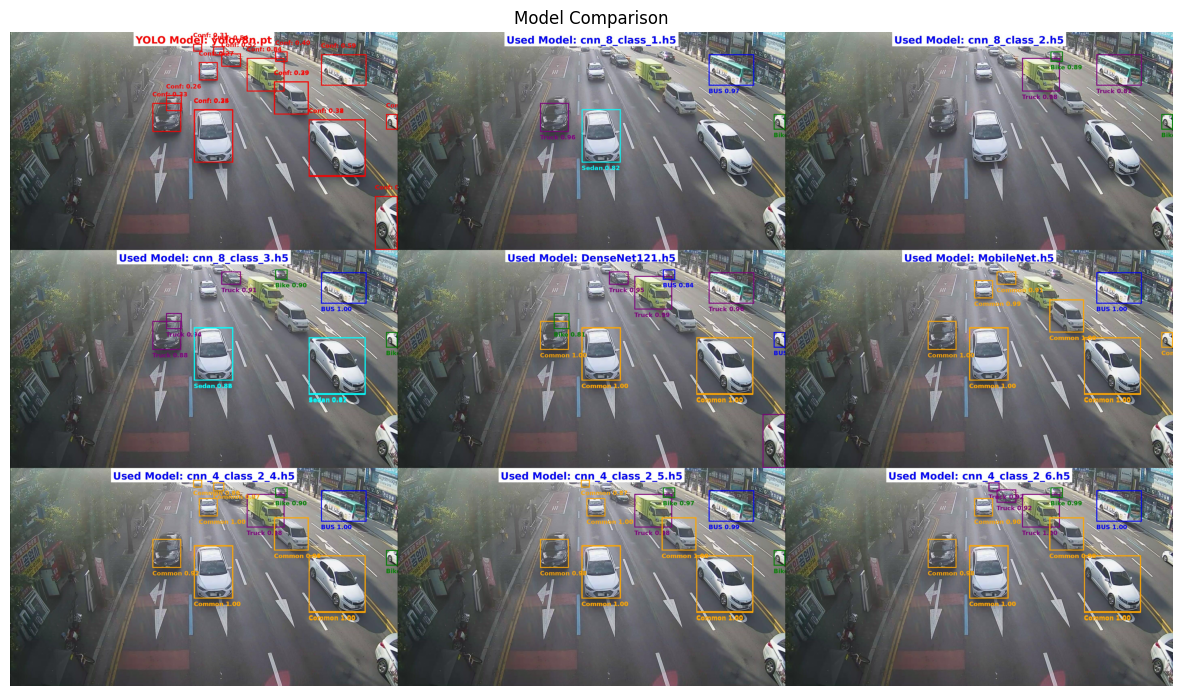

In [3]:
# 클래스 매핑
class_mapping_8_class = {
    0: 'BUS',
    1: 'Bike',
    2: 'HatchBack',
    3: 'SUV',
    4: 'Sedan',
    5: 'Truck',
    6: 'Truck2',
    7: 'Van'
}
class_mapping_4_class = {
    0: 'BUS',
    1: 'Bike',
    2: 'Common',
    3: 'Truck'
}

# 비교할 CNN 모델 리스트 (경로, 리사이즈 크기, 클래스 매핑)
model_paths = [
    ("../Jupiter/cnn_8_class/cnn_8_class_1/cnn_8_class_1.h5", (150, 150), class_mapping_8_class),
    ("../Jupiter/cnn_8_class/cnn_8_class_2/cnn_8_class_2.h5", (32, 32), class_mapping_8_class),
    ("../Jupiter/cnn_8_class/cnn_8_class_3/cnn_8_class_3.h5", (64, 64), class_mapping_8_class),
    ("../Jupiter/DenseNet121/DenseNet121.h5", (128, 128), class_mapping_4_class),
    ("../Jupiter/MobileNet/MobileNet.h5", (128, 128), class_mapping_4_class),
    #("../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_3.h5", (128, 128), class_mapping_4_class),
    ("../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_4.h5", (128, 128), class_mapping_4_class),
    ("../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_5.h5", (128, 128), class_mapping_4_class),
    ("../Jupiter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_6.h5", (128, 128), class_mapping_4_class),
]

# 테스트 이미지
test_image = "./test_img_2/test11.jpg"

# 모델 비교 수행
do_test_with_yolo_and_models(test_image, model_paths)
